In [1]:
import os
from pathlib import Path
from typing import Optional

import fastmri
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
from data_utils import *
from datasets import *
from fastmri.data.transforms import tensor_to_complex_np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from torch.utils.data import DataLoader, TensorDataset

from model import *
from torch.optim import SGD, Adam, AdamW
from train_utils import *

In [20]:
# model_checkpoint = '/scratch_net/ken/mcrespo/proj_marina/logs/multivol_11_20/2024-11-21_12h41m22s/checkpoints/epoch_0499.pt'  # TODO: SET (OR LEAVE COMMENTED).
model_checkpoint =  '/scratch_net/ken/mcrespo/proj_marina/logs/multivol_12_02/2024-12-02_17h59m57s/checkpoints/epoch_0999.pt'
# path_to_data = '/itet-stor/mcrespo/bmicdatasets-originals/Originals/fastMRI/brain/multicoil_train/'
n_volumes= 1
n_slices= 2
with_mask= True  # NOTE: During inference phase, set to True.
with_center= False
acceleration= 4
# vol_embedding_dim = 256
# coil_embedding_dim = 128
center_frac= 0.15
embedding_dim = 256
sigma = 0.1

coor_dim= 3
vol_embedding_dim= 256
coil_embedding_dim= 128
hidden_dim= 512
nlevels= 5
n_features= 3
n_min= 45
size_hashtable= 12
n_layers= 6
# dataset = KCoordDataset(path_to_data, n_volumes=n_volumes, n_slices=n_slices, with_mask=with_mask, acceleration=acceleration, center_frac=center_frac)

# Load checkpoint.
# model = Siren(coord_dim=3, vol_embedding_dim=vol_embedding_dim, coil_embedding_dim=coil_embedding_dim, hidden_dim=512, n_layers=8, out_dim=2)
# hash

model = Siren(coord_dim=3, levels=nlevels, n_min=n_min, size_hashtable=12, vol_embedding_dim=vol_embedding_dim, coil_embedding_dim=coil_embedding_dim, hidden_dim=512, n_layers=6, n_features=3)

# Load checkpoint.
checkpoint = torch.load(model_checkpoint,  map_location=torch.device('cpu'))

model_state_dict = checkpoint["model_state_dict"]
embedding_vol = checkpoint["embedding_state_dict"]

# model.load_state_dict(model_state_dict)
# print("Checkpoint loaded successfully.")


# #####################################################################
# # volume embedding
# #####################################################################
# embeddings_vol = torch.nn.Embedding(
#     len(dataset.metadata), vol_embedding_dim
# )
# torch.nn.init.normal_(
#     embeddings_vol.weight.data, 0.0, sigma
# )

# ###################################################################
# # Coil embeddings
# ########################################################
# coil_sizes = []
# for i in range(len(dataset.metadata)):
#     _, n_coils, _, _ = dataset.metadata[i]["shape"]
#     coil_sizes.append(n_coils)
    
# total_n_coils = torch.cumsum(torch.tensor(coil_sizes), dim=0)[-1]

# # # Create the indexes to access the embedding coil table
# start_idx = torch.tensor([0] + list(torch.cumsum(torch.tensor(coil_sizes), dim=0)[:-1]))

# # Create the table of embeddings for the coils
# embeddings_coil = torch.nn.Embedding(total_n_coils.item(), coil_embedding_dim)
# torch.nn.init.normal_(
#     embeddings_coil.weight.data, 0.0, sigma
# )

model.eval()

/tmp/ipykernel_25793/1915826978.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_checkpoint,  map_location=torch.device('cpu'))


Siren(
  (embed_fn): hash_encoder(
    (embeddings): ModuleList(
      (0): Embedding(2500, 3)
      (1-4): 4 x Embedding(4096, 3)
    )
  )
  (sine_layers): ModuleList(
    (0): SineLayer(
      (linear): Linear(in_features=400, out_features=512, bias=True)
    )
    (1-2): 2 x SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=912, out_features=512, bias=True)
    )
    (4-5): 2 x SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (output_layer): Linear(in_features=512, out_features=2, bias=True)
)

In [19]:
checkpoint.keys()

dict_keys(['model_state_dict', 'embedding_state_dict', 'optimizer_state_dict', 'scheduler_state_dict'])

In [14]:
for param in model.sine_layers.parameters():
    param.requires_grad = False
    
for param in model.output_layer.parameters():
    param.requires_grad = False

In [8]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 1.2862,  0.6554, -1.0597],
        [ 1.3477, -0.4864,  0.4090],
        [ 0.7518,  0.1012, -0.8124],
        ...,
        [ 2.0467, -1.6629, -1.7012],
        [-0.0078, -0.0039, -0.1635],
        [ 0.0569,  0.9161,  0.2738]], requires_grad=True)
Parameter containing:
tensor([[-0.7297, -0.4246, -0.2474],
        [ 0.9882, -0.5578, -0.3063],
        [ 0.3434, -1.6104,  0.5734],
        ...,
        [-0.2312,  1.5612, -0.4649],
        [-0.7884,  0.3844,  0.0316],
        [-0.0697, -0.9412, -0.1904]], requires_grad=True)
Parameter containing:
tensor([[-0.6634,  0.7404,  0.7496],
        [-0.8339, -0.7176,  1.9198],
        [-0.3588,  1.2251,  0.7861],
        ...,
        [-0.8957,  2.4866,  1.6073],
        [ 0.7802, -1.4858,  1.1529],
        [-0.4405,  1.7304, -3.1908]], requires_grad=True)
Parameter containing:
tensor([[ 1.9724, -1.0137, -0.7936],
        [ 0.7217,  0.8037,  0.6062],
        [ 0.6023, -0.3770, -0.0361],
        ...,
        [ 0.5937,  1

In [46]:
# embeddings_coil_tensor = torch.tensor(embedding_coil, requires_grad=True)
embedding_coil['weight']


tensor([[ 0.0401, -0.0387,  0.1106,  ...,  0.0706, -0.1736,  0.0322],
        [ 0.0976,  0.0297, -0.0230,  ...,  0.0110, -0.1567,  0.0502],
        [ 0.0045, -0.0743, -0.1747,  ..., -0.1158,  0.0308,  0.1615],
        ...,
        [ 0.0008,  0.1080, -0.0222,  ...,  0.0478,  0.0798, -0.0197],
        [-0.0309,  0.1145,  0.0030,  ...,  0.0327,  0.0821,  0.1473],
        [-0.1147,  0.0224,  0.1119,  ..., -0.0440, -0.1181,  0.0308]])

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-5.00142276e-01, -4.00142282e-01, -3.00142288e-01, -2.00142279e-01,
        -1.00142278e-01, -1.42275472e-04,  9.98577252e-02,  1.99857727e-01,
         2.99857736e-01,  3.99857730e-01,  4.99857724e-01]),
 <a list of 256 BarContainer objects>)

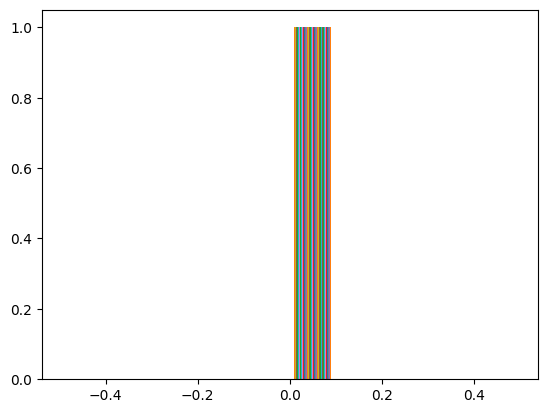

In [48]:
init_values = torch.mean(embedding_coil['weight'])

new_vol = torch.nn.Embedding(len(dataset.metadata), vol_embedding_dim)
new_vol.weight.data.copy_(init_values)

new_vol = new_vol.weight.detach()

plt.figure()
plt.hist(new_vol)

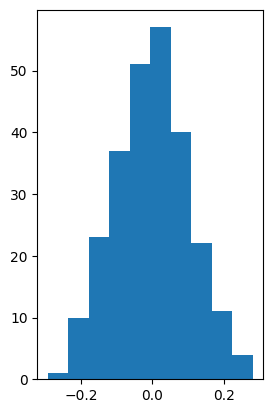

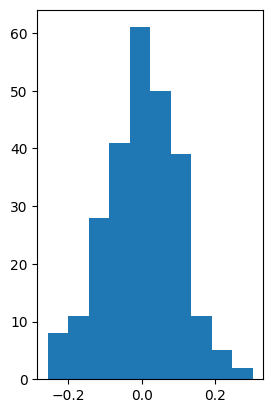

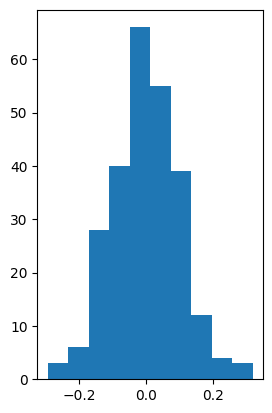

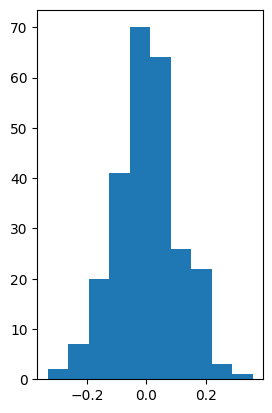

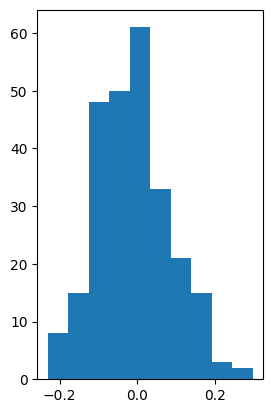

In [25]:
for i in range(embedding_vol['weight'].shape[0]):

    plt.figure()
    plt.subplot(1,2,1)
    plt.hist(embedding_vol['weight'][i])
    

In [5]:
dataloader = DataLoader(
    dataset,
    batch_size=1_000,
    num_workers=0,
    shuffle=True,
)

vol_id = 0
shape = dataloader.dataset.metadata[vol_id]["shape"]
center_data = dataloader.dataset.metadata[vol_id]["center"]
left_idx, right_idx, center_vals = (
    center_data["left_idx"],
    center_data["right_idx"],
    center_data["vals"],
)
n_slices, n_coils, height, width = shape

volume_kspace = torch.zeros(
    (n_slices, n_coils, height, width, 2),
    dtype=torch.float32,
)
predicted_volume = volume_kspace.clone()

for batch_idx, (inputs,inputs_unnormalized,targets) in enumerate(dataloader):
    
    coords = inputs[:, 1:-1] # kx,ky,kz
    vol_ids = inputs[:,0].long()
    coil_ids = inputs[:,-1].long() # unnormalized coilID
    
    latent_vol = embedding_vol[vol_ids]
    latent_coil = embedding_coil[start_idx[vol_ids] + coil_ids]

    # outputs = model(coords, latent_vol, latent_coil)
    
    # predicted_volume[inputs_unnormalized[:,2], inputs_unnormalized[:,3], inputs_unnormalized[:,1], inputs_unnormalized[:,0]] = outputs
    volume_kspace[inputs_unnormalized[:,2], inputs_unnormalized[:,3], inputs_unnormalized[:,1], inputs_unnormalized[:,0]] = targets

In [28]:
mask = dataloader.dataset.metadata[vol_id]["mask"]
mask_squeezed = mask.squeeze(-1)
mask_squeezed = mask_squeezed.expand(shape)
unmask = 1 - mask_squeezed

zeroed = tensor_to_complex_np(volume_kspace) * mask_squeezed.numpy()
non_zeroed = tensor_to_complex_np(volume_kspace) * unmask.numpy()



/tmp/ipykernel_17664/2760337998.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  predicted_volume = torch.load("./model_frozen_prediction_volID0.pth")


(-0.5, 319.5, 319.5, -0.5)

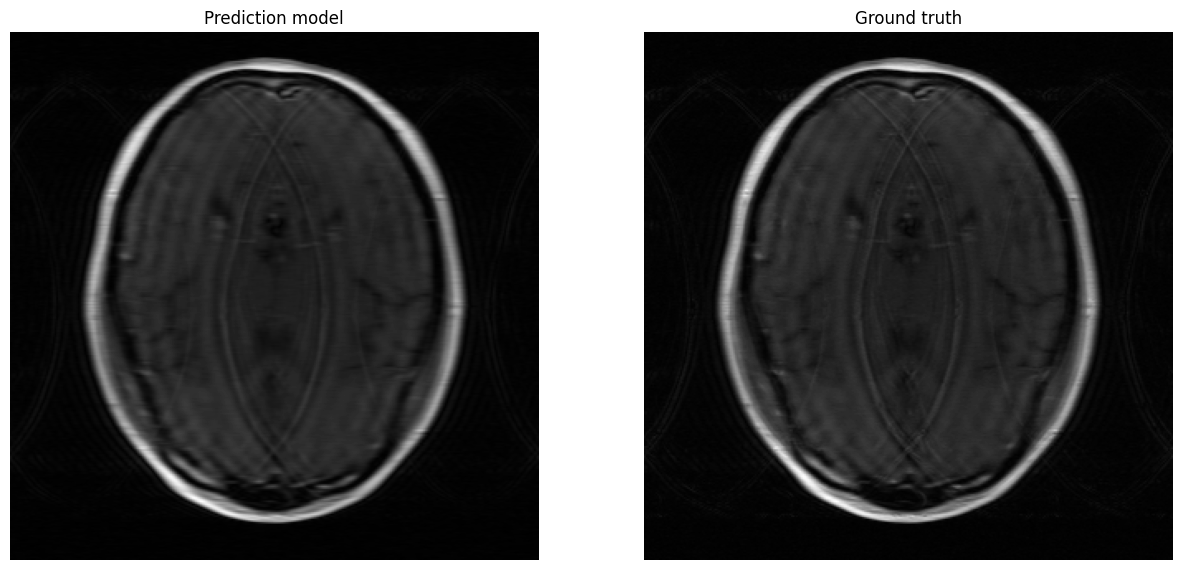

In [4]:
predicted_volume = torch.load("./model_frozen_prediction_volID0.pth")

gt_volume_kspace = (
    volume_kspace * dataloader.dataset.metadata[vol_id]["norm_cste"]
)
predicted_kspace = (predicted_volume * dataloader.dataset.metadata[vol_id]["norm_cste"])
# predicted_kspace = predicted_volume.clone()

predicted_kspace = tensor_to_complex_np(predicted_kspace.detach().cpu())
gt_volume_kspace = tensor_to_complex_np(gt_volume_kspace)


predicted_kspace[..., left_idx:right_idx] = center_vals
gt_volume_kspace[..., left_idx:right_idx] = center_vals

predicted_img = rss(inverse_fft2_shift(predicted_kspace))
gt_img = rss(inverse_fft2_shift(gt_volume_kspace))

predicted_kspace = fft2_shift(predicted_img)
gt_kspace = fft2_shift(gt_img)
eps = 1.e-45

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
# plt.imshow(np.log(np.abs(predicted_kspace[0]) + eps))
plt.imshow(np.abs(predicted_img[1]), cmap='gray')
plt.axis('off')
plt.title('Prediction model')
plt.subplot(1,2,2)
plt.imshow(np.abs(gt_img[1]), cmap='gray')
plt.title('Ground truth')
# plt.subplot(1,2,2)
# plt.imshow(np.log(np.abs(gt_kspace[0]) + eps))
plt.axis('off')

In [6]:
print(psnr(gt_img, predicted_img))
print(ssim(gt_img, predicted_img))

41.181192846564926
0.9651046377258448


In [ ]:
gt_volume_kspace = (
    volume_kspace * dataloader.dataset.metadata[vol_id]["norm_cste"]
)
predicted_kspace = (predicted_volume * dataloader.dataset.metadata[vol_id]["norm_cste"])


predicted_kspace = tensor_to_complex_np(predicted_kspace.detach().cpu())
gt_volume_kspace = tensor_to_complex_np(gt_volume_kspace)


predicted_kspace[..., left_idx:right_idx] = center_vals
gt_volume_kspace[..., left_idx:right_idx] = center_vals

predicted_img = rss(inverse_fft2_shift(predicted_kspace))
gt_img = rss(inverse_fft2_shift(gt_volume_kspace))

predicted_kspace = fft2_shift(predicted_img)
gt_kspace = fft2_shift(gt_img)
eps = 1.e-45

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(np.log(np.abs(predicted_kspace[0]) + eps))
# plt.imshow(np.abs(predicted_img[0]), cmap='gray')
plt.axis('off')
plt.title('Prediction model')
plt.subplot(1,2,2)
plt.colorbar()
# plt.imshow(np.abs(gt_img[0]), cmap='gray')
# plt.subplot(1,2,2)
plt.imshow(np.log(np.abs(gt_kspace[0]) + eps))
plt.title('Ground truth')
plt.axis('off')
plt.colorbar()

In [ ]:
torch.save(predicted_volume, "model_frozen_prediction_volID0.pth")

In [ ]:
dataset = KCoordDataset(path_to_data, n_volumes=n_volumes, n_slices=n_slices, with_mask=True, with_center=False, acceleration=4, center_frac=0.25)

dataloader_mask = DataLoader(
    dataset,
    batch_size=600_000,
    num_workers=0,
    shuffle=True,
)

vol_id = 0
shape = dataloader_mask.dataset.metadata[vol_id]["shape"]
center_data = dataloader_mask.dataset.metadata[vol_id]["center"]
left_idx, right_idx, center_vals = (
    center_data["left_idx"],
    center_data["right_idx"],
    center_data["vals"],
)
n_slices, n_coils, height, width = shape

volume_kspace_masked = torch.zeros(
    (n_slices, n_coils, height, width, 2),
    dtype=torch.float32,
)

for batch_idx, (inputs,inputs_unnormalized,targets) in enumerate(dataloader_mask):
    volume_kspace_masked[inputs_unnormalized[:,2], inputs_unnormalized[:,3], inputs_unnormalized[:,1], inputs_unnormalized[:,0]] = targets
    

In [ ]:
gt_volume_kspace = (
    volume_kspace_masked * dataloader_mask.dataset.metadata[vol_id]["norm_cste"]
)

gt_volume_kspace = tensor_to_complex_np(gt_volume_kspace)

# gt_volume_kspace[..., left_idx:right_idx] = center_vals


gt_img = rss(inverse_fft2_shift(gt_volume_kspace))

modulus_kspace = fft2_shift(gt_img)
# modulus_kspace[..., left_idx:right_idx] = 0

eps = 1.e-45

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(np.log(np.abs(modulus_kspace[0])))
plt.axis('off')
plt.title('log(modulus)')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.abs(gt_img[0]), cmap='gray')
# plt.subplot(1,2,2)
# plt.imshow(np.log(np.abs(gt_kspace[0]) + eps))
plt.axis('off')



In [ ]:
gt_modulus = np.abs(fft2_shift(gt_img))
predicted_modulus = np.abs(fft2_shift(predicted_img))


plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(np.log(gt_modulus[0] + eps))
plt.axis('off')
plt.title('Undersampled groundtruth')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.log(predicted_modulus[0] + eps))
plt.axis('off')
plt.title('Undersampled predictions')
plt.colorbar()

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(2, 2, 1)
plt.imshow(np.log(gt_modulus[0] / dataloader.dataset.metadata[vol_id]["norm_cste"] + eps))
plt.axis('off')
plt.colorbar()
plt.title("Kspace")
plt.subplot(2, 2, 2)
plt.hist(np.log(gt_modulus[0].flatten()), log=True, bins=100)
plt.subplot(2, 2, 3)
plt.imshow(np.log(predicted_modulus[0] / dataloader.dataset.metadata[vol_id]["norm_cste"] + eps))
plt.axis('off')
plt.colorbar()
plt.title("Kspace")
plt.subplot(2, 2, 4)
plt.hist(np.log(predicted_modulus[0].flatten()), log=True, bins=100)
plt.show()


In [ ]:
vol_id = 0
file = dataloader.dataset.metadata[vol_id]["file"]
with h5py.File(file, "r") as hf:
    ground_truth = hf["reconstruction_rss"][()][: n_slices]
    
modulus = np.abs(fft2_shift(ground_truth))



In [ ]:
plt.imshow(np.log(modulus[0]) + eps)
# plt.imshow(ground_truth[0], cmap='gray')
plt.axis('off')
plt.colorbar()